---
**License**

 TestInterp -- Rosenbrock

 Mon Jan 25 20:56:00 2020\
 Copyright  2021\
 Eduardo ...\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 TestInterp-Resenbrock\
 Copyright (C) 2021 Eduardo ...\
 Copyright (C) 2021 Sandro Dias Pinto Vitenti <vitenti@uel.br>


 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import numpy as np
import scipy.stats
from scipy.optimize import minimize
from pylab import figure, cm

from IPython.display import HTML, display
import tabulate

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
dim = 2
nps = 500 # Dataset size

rng = Ncm.RNG.seeded_new (None, 123)

sigma1 = math.sqrt (10.0)
sigma2 = 1.0 / sigma1
mu1 = 1.0

def m2lnL_val (va):
    return (mu1 - va[0])**2 / sigma1**2 + (va[1] - va[0]**2)**2 / sigma2**2


In [4]:
interps = []
interps_desc = []

kernel0 = Ncm.StatsDistKernelST.new (dim, 1.0)
interp0 = Ncm.StatsDistKDE.new (kernel0, Ncm.StatsDistCV.NONE)
interps.append (interp0)
interps_desc.append ("KDE ST1")

kernel1 = Ncm.StatsDistKernelST.new (dim, 3.0)
interp1 = Ncm.StatsDistKDE.new (kernel1, Ncm.StatsDistCV.NONE)
interps.append (interp1)
interps_desc.append ("KDE ST3")

kernel2 = Ncm.StatsDistKernelGauss.new (dim)
interp2 = Ncm.StatsDistKDE.new (kernel2, Ncm.StatsDistCV.NONE)
interps.append (interp2)
interps_desc.append ("KDE Gauss")

kernel3 = Ncm.StatsDistKernelST.new (dim, 1.0)
interp3 = Ncm.StatsDistVKDE.new (kernel3, Ncm.StatsDistCV.NONE)
interps.append (interp3)
interps_desc.append ("VKDE ST1")

kernel4 = Ncm.StatsDistKernelST.new (dim, 3.0)
interp4 = Ncm.StatsDistVKDE.new (kernel4, Ncm.StatsDistCV.NONE)
interps.append (interp4)
interps_desc.append ("VKDE ST3")

kernel5 = Ncm.StatsDistKernelGauss.new (dim)
interp5 = Ncm.StatsDistVKDE.new (kernel5, Ncm.StatsDistCV.NONE)
interps.append (interp5)
interps_desc.append ("VKDE Gauss")


In [5]:
for interp in interps:
    interp.reset ()

theta_train = [] # Training set variables
m2lnp_train = [] # Training set m2lnp

for i in range (nps):
    x1 = rng.gaussian_gen (mu1, sigma1)
    x2 = rng.gaussian_gen (x1*x1, sigma2)
    
    theta_i = [x1, x2]
    m2lnp_i = m2lnL_val (theta_i)

    theta_train.append (theta_i)
    m2lnp_train.append (m2lnp_i)

    theta_v_i = Ncm.Vector.new_array (theta_i)
    for interp in interps:
        interp.add_obs (theta_v_i)

theta_train = np.array (theta_train)
m2lnp_train = np.array (m2lnp_train)

theta_test = [] # Test set variables
m2lnp_test = [] # Test set m2lnp

for i in range (nps):
    x1 = rng.gaussian_gen (mu1, sigma1)
    x2 = rng.gaussian_gen (x1*x1, sigma2)
    
    theta_i = [x1, x2]
    m2lnp_i = m2lnL_val (theta_i)

    theta_test.append (theta_i)
    m2lnp_test.append (m2lnp_i)

    theta_v_i = Ncm.Vector.new_array (theta_i)
    for interp in interps:
        interp.add_obs (theta_v_i)

theta_test = np.array (theta_test)
m2lnp_test = np.array (m2lnp_test)


In [6]:
for interp in interps:
    interp.set_cv_type (Ncm.StatsDistCV.SPLIT)
    interp.set_split_frac (0.5)

    m2lnp_tot = Ncm.Vector.new_array (np.concatenate ((m2lnp_train, m2lnp_test)))

    interp.prepare_interp (m2lnp_tot)
    calib_os = interp.get_over_smooth ()

    print ("Calibrate interpolation with os = % 22.15g and rnorm = % 22.15g" % (calib_os, interp.get_rnorm ()))

Calibrate interpolation with os =      0.108534031880035 and rnorm =       9.11496304740636
Calibrate interpolation with os =      0.100764191102254 and rnorm =       7.86212096740345
Calibrate interpolation with os =     0.0634195514458711 and rnorm =       7.17174116383551
Calibrate interpolation with os =      0.232312198949156 and rnorm =       1.00205207755704
Calibrate interpolation with os =      0.216386267184948 and rnorm =      0.466667336054821
Calibrate interpolation with os =      0.137220109649476 and rnorm =      0.207379517091806


In [7]:
for interp in interps:
    interp.reset () 

for theta in theta_train:
    theta_v = Ncm.Vector.new_array (theta)
    for interp in interps:
        interp.add_obs (theta_v)

m2lnp_interps = []
        
for interp in interps:
    interp.set_cv_type (Ncm.StatsDistCV.NONE)
    interp.set_split_frac (1.0)
    interp.prepare_interp (Ncm.Vector.new_array (m2lnp_train))
    
    m2lnp_interp = []
    for theta in theta_test:
        m2lnp_interp.append (interp.eval_m2lnp (Ncm.Vector.new_array (theta)))
    m2lnp_interp = np.array (m2lnp_interp)
    
    m2lnp_interps.append (m2lnp_interp)

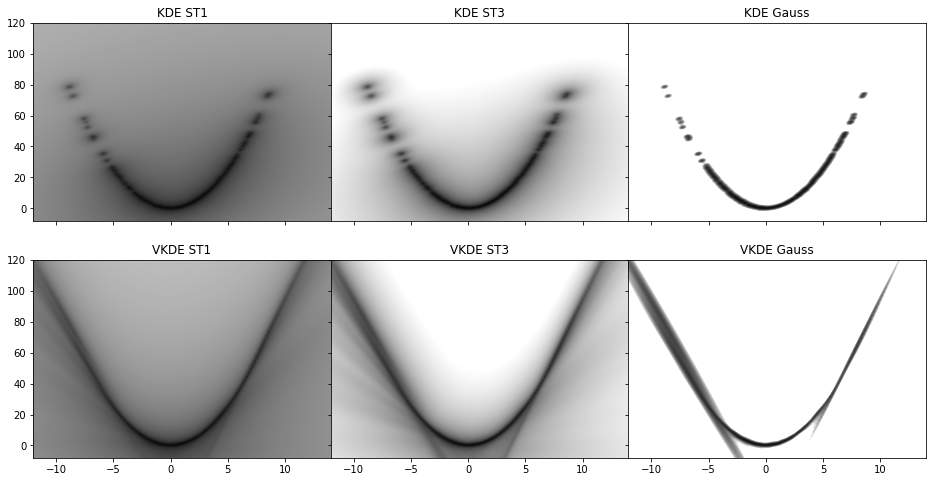

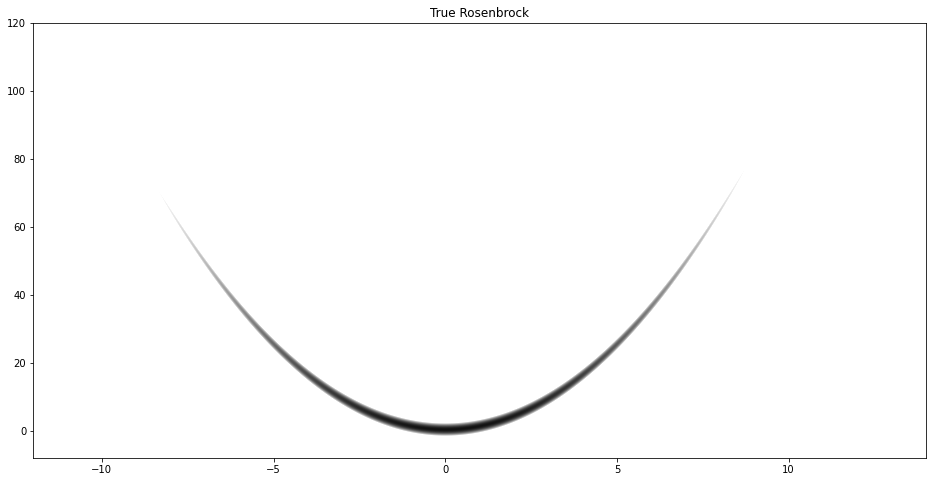

In [8]:
plotn = 150

fig, axa = plt.subplots(2,3, figsize=(16, 8), sharex=True, sharey=True)
axa = [ax for subaxa in axa for ax in subaxa]

x1_a = np.linspace (-12, 14, plotn)
x2_a = np.linspace (-8, 120, plotn)

for interp, interp_desc, ax0 in zip (interps, interps_desc, axa):
    
    z = np.array([interp.eval_m2lnp (Ncm.Vector.new_array ([x1, x2])) for x2 in x2_a for x1 in x1_a])
    z = z - min(z)
    Z = z.reshape (plotn, plotn)
        
    ax0.imshow(Z, interpolation='bicubic', origin='lower', cmap=cm.gray, 
               norm=Normalize(vmin=0.0, vmax=40), 
               extent = [x1_a[0], x1_a[-1], x2_a[0], x2_a[-1]], aspect="auto")
    ax0.set_title (interp_desc)

plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.show ()

plt.figure (figsize=(16, 8))

zT = np.array([m2lnL_val ([x1, x2]) for x2 in x2_a for x1 in x1_a])
ZT = zT.reshape (plotn, plotn)
plt.imshow(ZT, interpolation='bicubic', origin='lower', cmap=cm.gray, 
           norm=Normalize(vmin=0.0, vmax=40), 
           extent = [x1_a[0], x1_a[-1], x2_a[0], x2_a[-1]], aspect="auto")
plt.title ("True Rosenbrock")


pass

In [9]:
table = [[None, "mean error", "log-mean error", "Probability accept", "zero gauge"]]

diffs = []
probs = []

for interp, interp_desc, m2lnp_interp in zip (interps, interps_desc, m2lnp_interps):

    p_test   = np.exp (-0.5 * m2lnp_test)
    p_interp = np.exp (-0.5 * m2lnp_interp)

    m        = -interp.eval_m2lnp(Ncm.Vector.new_array ([0.0, 0.0]))
    exp_m    = 1.0 / interp.eval (Ncm.Vector.new_array ([0.0, 0.0]))
    diff     = (m2lnp_interp + m) / m2lnp_test - 1.0
    exp_diff = (p_interp * exp_m) / p_test - 1.0
    
    prob = np.minimum(np.exp (-0.5*((m2lnp_interp[0::2]-m2lnp_test[0::2])-(m2lnp_interp[1::2]-m2lnp_test[1::2]))), 1.0)
    
    diffs.append (diff)
    probs.append (prob)

    mean_err0 = 10**(np.mean (np.log10 (np.abs (exp_diff))))
    mean_err1 = 10**(np.mean (np.log10 (np.abs (diff))))
    
    line = [interp_desc]
    line.append ("%.1f%%" % (100.0 * mean_err0))
    line.append ("%.1f%%" % (100.0 * mean_err1))
    line.append ("%.1f%%" % (100.0 * np.mean (prob)))
    line.append ("%.3f" % (m))
    table.append (line)
display(HTML(tabulate.tabulate(table, tablefmt='html')))

<ipython-input-9-1b56c9d11ec1>:16: RuntimeWarning: overflow encountered in exp
  prob = np.minimum(np.exp (-0.5*((m2lnp_interp[0::2]-m2lnp_test[0::2])-(m2lnp_interp[1::2]-m2lnp_test[1::2]))), 1.0)


,mean error,log-mean error,Probability accept,zero gauge
KDE ST1,23.1%,47.6%,78.7%,0.411
KDE ST3,18.9%,38.8%,79.6%,0.246
KDE Gauss,15.1%,32.9%,80.5%,0.099
VKDE ST1,4.4%,8.1%,91.2%,-0.078
VKDE ST3,4.7%,8.7%,92.4%,-0.085
VKDE Gauss,5.6%,10.6%,93.6%,-0.093


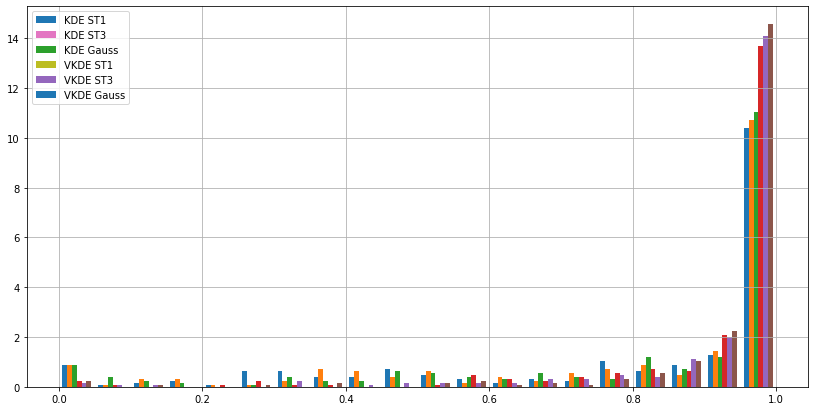

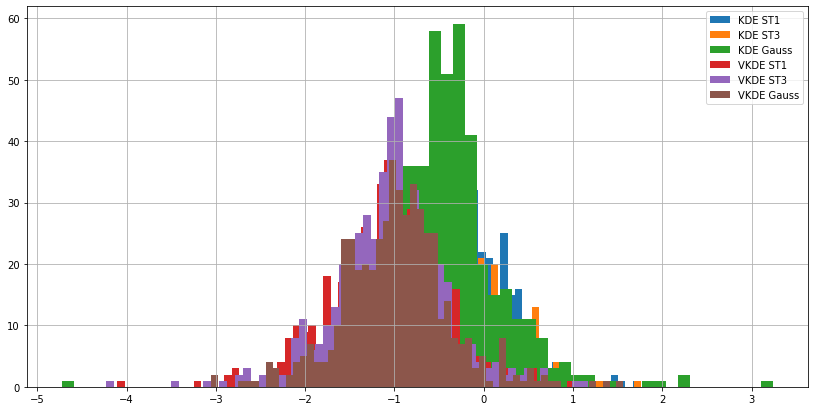

In [10]:
plt.figure (figsize=(14, 7))

for diff, prob, interp_desc in zip (diffs, probs, interps_desc):
    plt.hist (probs, label=interp_desc, bins = 20, density=True)
plt.grid ()
plt.legend(loc='best')
plt.show ()

plt.figure (figsize=(14, 7))

for diff, prob, interp_desc in zip (diffs, probs, interps_desc):
    plt.hist (np.log10 (np.abs (diff)), bins = 60, label=interp_desc)
    #plt.hist (np.log10 (np.abs (exp_diff)), bins = 60, label=r'$|y_i/y_a - 1|$')

plt.grid ()
plt.legend(loc='best')
plt.show ()


pass

In [11]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mu, cov, ax, n_std=1.0, facecolor='none', **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)



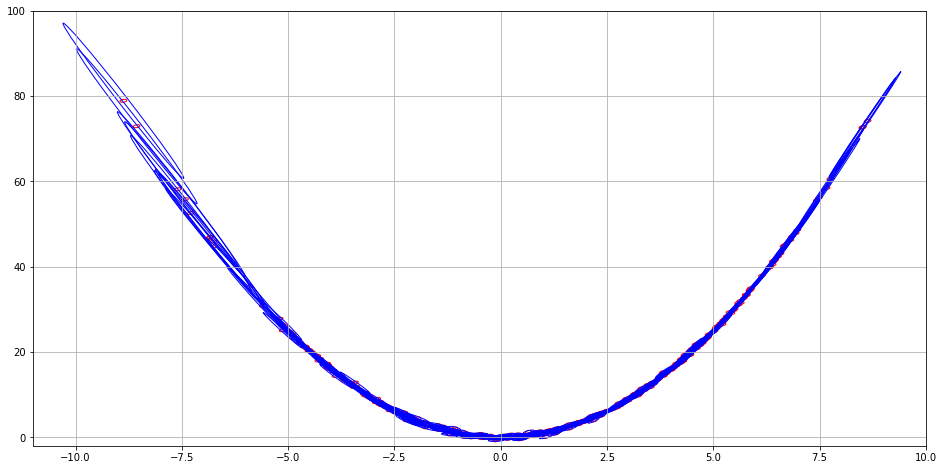

In [12]:
#
#    y_i, cov_i, n_i, w_i = interp.get_Ki (i)
#    print (n_i, w_i)
#    cov_i.log_vals ("COV: ", "%f")

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i in range (0,interps[0].get_sample_size ()):
    y_i, cov_i, n_i, w_i = interps[0].get_Ki (i)
    mu  = y_i.dup_array ()
    cov = np.array ([[cov_i.get (i, j) for j in range (2)] for i in range (2)])
    cov = cov * 1.0

    confidence_ellipse (mu, cov, ax, edgecolor='red')

for i in range (0,interps[3].get_sample_size ()):
    y_i, cov_i, n_i, w_i = interps[3].get_Ki (i)
    mu  = y_i.dup_array ()
    cov = np.array ([[cov_i.get (i, j) for j in range (2)] for i in range (2)])
    cov = cov * 1.0

    confidence_ellipse (mu, cov, ax, edgecolor='blue')

ax.set_xlim ([-11,10])
ax.set_ylim ([-2,100])
plt.grid ()
